<a href="https://colab.research.google.com/github/ahmad-PH/nag-notebooks/blob/master/NAG_tripletLossExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import os; import subprocess

def detect_env():
    return 'colab' if 'content' in os.listdir('/') else 'IBM'
  
def run_shell_command(cmd):
  p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
  print(str(p.communicate()[0], 'utf-8'))
  
if detect_env() == 'colab': root_folder = '/content'
elif detect_env() == 'IBM' : root_folder = '/root/Derakhshani/adversarial'
python_files_path = root_folder + '/nag-public'

if os.path.isdir(python_files_path):
  initial_dir = os.getcwd()
  os.chdir(python_files_path)
  run_shell_command('git pull')
  os.chdir(initial_dir)
else:
  os.chdir('/root/Derakhshani/adversarial')
  run_shell_command('git clone https://github.com/ahmad-PH/nag-public.git')

Already up-to-date.



In [85]:
import sys
sys.path.append(python_files_path + '/NAG-11May-beforeDenoiser')

from nag_util import *
import nag_util
from environment import *
from visualization import *

env = create_env()
env.setup(cuda_index = 0)

In [86]:
from fastai.vision import *
from fastai.imports import *
from fastai.callbacks import *
from fastai.utils.mem import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import sys; import os; import shutil

In [87]:
class GeneralRelu(nn.Module):
  def __init__(self, leak=None, sub=None, maxv=None):
    super().__init__()
    self.leak,self.sub,self.maxv = leak,sub,maxv

  def forward(self, x): 
    x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
    if self.sub is not None: x.sub_(self.sub)
    if self.maxv is not None: x.clamp_max_(self.maxv)
    return x
  
class deconv_layer(nn.Module):
    def __init__(self, in_ch, out_ch, k_size = (4,4), s = (2,2), pad = (1,1), b = True, activation = True):
        super(deconv_layer, self).__init__()

        self.CT2d = nn.ConvTranspose2d(in_channels = in_ch,
                                  out_channels = out_ch,
                                  kernel_size = k_size,
                                  stride = s, 
                                  padding = pad,
                                  bias = b)
        self.BN2d = nn.BatchNorm2d(out_ch)
        
        self.activation = activation
        if self.activation:
            self.relu = GeneralRelu(0, 0.2, 5)
        
        self.weight_init()
    
    def forward(self, input):
        if self.activation:
            return self.relu(self.BN2d(self.CT2d(input)))
        else:
            return self.BN2d(self.CT2d(input))

    def weight_init(self):
        self.CT2d.weight.data.normal_(mean = 0, std = 0.02)
        self.CT2d.bias.data.fill_(0)


In [88]:
# class Gen(nn.Module):
#   def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
#     super(Gen, self).__init__()

#     self.bs = None
#     self.z_dim = z_dim
#     self.gf_dim = gf_dim
#     self.y_dim = y_dim
#     self.df_dim = df_dim
#     self.image_shape = image_shape

#     self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
#     self.z_.bias.data.fill_(0)
#     self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

#     self.half = max(self.gf_dim // 2, 1) 
#     self.quarter = max(self.gf_dim // 4, 1)
#     self.eighth = max(self.gf_dim // 8, 1)
#     # sixteenth = max(self.gf_dim // 16, 1)
    
#     self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
#     self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)    
#     self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)
#     self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)
#     self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
#     self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
#     self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

#   def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
#     h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
#     h_input = torch.cat([h_input, h_input_z], dim = 1)
#     output = deconv_layer(h_input)
#     assert output.shape[2:] == (expected_output_size, expected_output_size), \
#             "Unexpected output shape at randomized_deconv_layer. expected" + \
#             "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
#     return output
  
#   def forward_z(self, z):
#     self.bs = z.shape[0]
    
#     h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
#     assert h0.shape[2:] == (4, 4), "Unexpected shape, it shoud be (4,4)"

#     h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
#     h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
#     h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
#     h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
#     h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
#     h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
#     h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

#     ksi = 10.0
#     output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
#     # this coeff scales the output to be appropriate for images that are 
#     # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
#     # interval)
#     return output_coeff * torch.tanh(h7)
  
# #   # blind-selection
#   def forward(self, inputs):
#     self.bs = inputs.shape[0]

#     benign_preds_onehot = arch(inputs)
#     benign_preds = torch.argmax(benign_preds_onehot, dim = 1)
    
#     z = torch.zeros([self.bs, 1000]).cuda()
#     for i in range(self.bs):
#       random_label = self.randint(0,1000, exclude = benign_preds[i].item())
#       z[i][random_label] = 1.
    
#     z_out = self.forward_z(z)
    
#     return z_out, None, None, inputs, benign_preds_onehot, z

# #   #second-best selection: made validation so much worse
# #   def forward(self, inputs):
# #     self.bs = inputs.shape[0]

# #     benign_preds_onehot = arch(inputs)
# #     target_preds = torch.topk(benign_preds_onehot, 2, dim = 1).indices[:, 1:]
    
# #     z = torch.zeros([self.bs, 1000]).cuda()
# #     for i in range(self.bs):
# #       z[i][target_preds[i]] = 1.
    
# #     z_out = self.forward_z(z)
    
# #     return z_out, None, None, inputs, benign_preds_onehot, z
  
# #    def forward(self, inputs):
# #     self.bs = inputs.shape[0]

# #     benign_preds_onehot = arch(inputs)
# #     benign_preds = torch.argmax(benign_preds_onehot, dim = 1)
    
# #     z = torch.zeros([self.bs, 1000]).cuda()
# #     random_label = self.randint(0,1000, exclude = benign_preds.tolist())
# #     for i in range(self.bs):
# #       z[i][random_label] = 1.
    
# #     z_out = self.forward_z(z)
    
# #     return z_out, None, None, inputs, benign_preds_onehot, z
  
#   @staticmethod
#   def randint(low, high, exclude):
#     temp = np.random.randint(low, high - 1)
#     if temp == exclude:
#       temp = temp + 1
#     return temp
  
#   def forward_single_z(self, z):
#     return self.forward_z(z[None]).squeeze()
           
  
#   def make_triplet_samples(self, z, margin, r2, r3):
#     positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
#     negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
#     return positive_sample, negative_sample

#   def random_vector_surface(self, shape, r = 1.):
#     mat = torch.randn(size=shape).cuda()
#     norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
#     return (mat/norm) * r

  
#   def random_vector_volume(self, shape, inner_r, outer_r):
#     fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
#     fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
#     fraction.unsqueeze_(-1)
#     return self.random_vector_surface(shape, 1) * fraction

#   def make_z(self, in_shape):
#     return torch.empty(in_shape).cuda().uniform_(-1,1)


In [89]:
# non-targeted Gen
class Gen(nn.Module):
  def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
    super(Gen, self).__init__()

    self.bs = None
    self.z_dim = z_dim
    self.gf_dim = gf_dim
    self.y_dim = y_dim
    self.df_dim = df_dim
    self.image_shape = image_shape

    self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
    self.z_.bias.data.fill_(0)
    self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

    self.half = max(self.gf_dim // 2, 1) 
    self.quarter = max(self.gf_dim // 4, 1)
    self.eighth = max(self.gf_dim // 8, 1)
    # sixteenth = max(self.gf_dim // 16, 1)

    self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
    self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)    
    self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)
    self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)
    self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
    self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
    self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

  def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
    h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
    h_input = torch.cat([h_input, h_input_z], dim = 1)
    output = deconv_layer(h_input)
    assert output.shape[2:] == (expected_output_size, expected_output_size), \
            "Unexpected output shape at randomized_deconv_layer. expected" + \
            "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
    return output
  
  def forward_z(self, z):
    self.bs = z.shape[0]
    
    h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
    assert h0.shape[2:] == (4, 4), "Non-expected shape, it shoud be (4,4)"

    h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
    h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
    h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
    h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
    h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
    h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
    h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

    ksi = 10.0
    output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
    # this coeff scales the output to be appropriate for images that are 
    # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
    # interval)
    return output_coeff * torch.tanh(h7)

  def forward(self, inputs):
    self.bs = inputs.shape[0]
    z = inputs.new_empty([self.bs, self.z_dim]).uniform_(-1,1).cuda()
    p, n = self.make_triplet_samples(z, 0.1, 0.1, 2.)
    
    z_out = self.forward_z(z)
    p_out = self.forward_z(p)
    n_out = self.forward_z(n)
    
    return z_out, p_out, n_out, inputs
#     return z_out, None, None, inputs
  
  def forward_single_z(self, z):
    return self.forward_z(z[None]).squeeze()
           
  
  def make_triplet_samples(self, z, margin, r2, r3):
    positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
    negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
    return positive_sample, negative_sample

  def random_vector_surface(self, shape, r = 1.):
    mat = torch.randn(size=shape).cuda()
    norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
    return (mat/norm) * r

  
  def random_vector_volume(self, shape, inner_r, outer_r):
    fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
    fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
    fraction.unsqueeze_(-1)
    return self.random_vector_surface(shape, 1) * fraction

  def make_z(self, in_shape):
    return torch.empty(in_shape).cuda().uniform_(-1,1)

In [90]:
def js_distance(x1, x2):
  m = 0.5 * (x1 + x2)
  return 0.5 * (F.kl_div(x1, m) + F.kl_div(x2, m))

def kl_distance(x1, x2):
  inp = torch.log(x1)
  target = x2
  return F.kl_div(inp, target, reduction='batchmean')

def distrib_distance(x1, x2):
  x1 = tensorify(x1)
  x2 = tensorify(x2)
  x1 = x1 / torch.sum(x1)
  x2 = x2 / torch.sum(x2)
  return kl_distance(x1[None], x2[None])

def distrib_distance(x1, x2):
  if not isinstance(x1, torch.Tensor): x1 = torch.tensor(x1)
  if not isinstance(x2, torch.Tensor): x2 = torch.tensor(x2)
  x1 = x1 * 100. / torch.sum(x1)
  x2 = x2 * 100. / torch.sum(x2)
  return torch.norm(x1 - x2, 2)

def distance_from_uniform(x):
  return distrib_distance(x, [1.] * len(x))

def wasserstein_distance(x1, x2):
  return torch.mean(x1 - x2)

def l1_distance(x1, x2):
  return F.l1_loss(x1, x2)

def l2_distance(x1, x2):
  return F.mse_loss(x1 * 10, x2 * 10)

def mse_loss(x1, x2):
  return F.mse_loss(x1, x2)

def cos_distance(x1, x2, dim = 1):
  return -1 * torch.mean(F.cosine_similarity(x1, x2, dim=dim))


def triplet_loss(anchor, positive, negative, distance_func, margin):
  # max distance when using l1_distance is 2
  # max distacne when using l2-distance is sqrt(2)
#   print("anchor: ", anchor.min(), anchor.max())
  ap_dist = distance_func(anchor, positive)
  an_dist = distance_func(anchor, negative)

  triplet_loss.call_count += 1
  if triplet_loss.call_count % 10 in [0,1] : #and anchor.shape[1] == 1000:
#     print("a: ", end=""); print_big_vector(anchor[0])
#     print("p: ", end=""); print_big_vector(positive[0])
#     print("n: ", end=""); print_big_vector(negative[0])
    print("func:{}, ap_dist: {}, an_dist: {}".format(distance_func.__name__, ap_dist, an_dist))
    
  return torch.mean(F.relu(ap_dist - an_dist + margin))

triplet_loss.call_count = 0

In [91]:
def diversity_loss(input, target):
#   return -1 * torch.mean(torch.pow(f_x_a-f_x_s,2))
  if input.shape[0] != batch_size:
    print("input shape: ", input.shape)
    print("target shape: ", target.shape, "\n\n")
  return torch.mean(F.cosine_similarity(
    input.view([batch_size, -1]),
    target.view([batch_size, -1]), 
  ))


def fool_loss(input, target):
  true_class = torch.argmax(target, dim=1).view(-1,1).long().cuda()
  target_probabilities = input.gather(1, true_class)
  epsilon = 1e-10
  result =  torch.mean(-1 * torch.log(1 - target_probabilities + epsilon))
  
  fool_loss.call_count += 1
  if fool_loss.call_count % 40 == 0:
    print("target probs {}, loss: {}: ".format(target_probabilities, result))
    
  return result

fool_loss.call_count = 0

# def fool_loss(model_output, target_labels):
#   target_labels = target_labels.view(-1, 1).long().cuda()
#   target_probabilities = model_output.gather(1, target_labels)
#   epsilon = 1e-10
#   # highest possible fool_loss is - log(1e-10) == 23
#   result = torch.mean(-1 * torch.log(target_probabilities + epsilon))
  
#   global fool_loss_count
#   fool_loss_count += 1
#   if fool_loss_count % 20 == 0:
#     print("target probs {}, loss: {}: ".format(target_probabilities, result))
  
#   return result

# def validation(gen_output, target):
#   perturbations, _, _, clean_images, _, _ = gen_output
#   perturbed_images = clean_images + perturbations
#   benign_preds = torch.argmax(arch(clean_images), 1)
#   adversary_preds = torch.argmax(arch(perturbed_images), 1)
#   return (benign_preds != adversary_preds).float().mean()

def validation(gen_output, target):
  perturbations, _, _, clean_images = gen_output
  perturbed_images = clean_images + perturbations
  benign_preds = torch.argmax(arch(clean_images), 1)
  adversary_preds = torch.argmax(arch(perturbed_images), 1)
  return (benign_preds != adversary_preds).float().mean()


In [92]:
# class FeatureLoss(nn.Module):
#     def __name__(self):
#       return "feature_loss"
  
#     def __init__(self, dis, layers, layer_weights):
#         super().__init__()
        
#         # define generator here 
#         self.dis = dis
#         self.diversity_layers = layers
#         self.hooks = hook_outputs(self.diversity_layers, detach=False)
#         self.weights = layer_weights
#         self.metric_names = ["fool_loss"] #+ [f"div_loss_{i}" for i in range(len(layers))] #maybe Gram
# #         self.triplet_hooks = hook_outputs([arch.m.features[4]], detach=False)
    
#     def make_features(self, x, clone=False):
#         y = self.dis(x)
#         return y, [(o.clone() if clone else o) for o in self.hooks.stored]
  
#     def forward(self, inp, target):
#       sigma_B, _, _, X_B, B_Y, z = inp

#       X_A = X_B + sigma_B
# #       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       A_Y, A_feat = self.make_features(X_A)
# #       _, S_feat = self.make_features(X_S)

#       chosen_labels = z.argmax(dim=1)
#       fooling_loss =  fool_loss(A_Y, chosen_labels)

# #       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
# #       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

# #       self.losses = [fooling_loss] + weighted_diversity_losses
# #       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

#       self.losses = [fooling_loss]
#       self.metrics = dict(zip(self.metric_names, [fooling_loss]))

#       return sum(self.losses)
  
#     def add_perturbation_shuffled(self, inp, perturbation):
# #         j = torch.randperm(inp.shape[0])
#         j = derangement(inp.shape[0])
#         return inp.add(perturbation[j])

In [93]:
#non-targeted FeatureLoss
class FeatureLoss(nn.Module):
    def __name__(self):
      return "feature_loss"
  
    def __init__(self, dis, layers, layer_weights):
        super().__init__()
        
        # define generator here 
        self.dis = dis
        self.diversity_layers = layers
        self.hooks = hook_outputs(self.diversity_layers, detach=False)
        self.weights = layer_weights
        
        
        self.metric_names = ["fool_loss"] + [f"div_loss_{i}" for i in range(len(layers))] + ['triplet_loss']# Maybe Gram
#         self.metric_names = ["fool_loss"] + ['triplet_loss']# Maybe Gram
#         self.metric_names = ["fool_loss"] + ['div_loss']# Maybe Gram
        self.triplet_weight = 4.
        self.div_weight = 1.
    
    def make_features(self, x, clone=False):
        y = self.dis(x)
        return y, [(o.clone() if clone else o) for o in self.hooks.stored]
    
#     triplet loss
    def forward(self, inp, target):
        sigma_B, sigma_pos, sigma_neg, X_B = inp

        X_A = self.add_perturbation(X_B, sigma_B) 
        X_A_pos = self.add_perturbation(X_B, sigma_pos)
        X_A_neg = self.add_perturbation(X_B, sigma_neg) 
        
        X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples
        
        B_Y, _ = self.make_features(X_B)
        A_Y, A_feat = self.make_features(X_A)
        _, S_feat = self.make_features(X_S)
        pos_softmax, _ = self.make_features(X_A_pos)
        neg_softmax, _ = self.make_features(X_A_neg)
        
        fooling_loss =  fool_loss(A_Y, B_Y)
      
        raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
        weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight * self.div_weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
        raw_triplet_loss = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
        weighted_triplet_loss = raw_triplet_loss * self.triplet_weight
    
        self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss]
        self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [raw_triplet_loss]))
#         self.losses = [fooling_loss] + [weighted_triplet_loss]
#         self.metrics = dict(zip(self.metric_names, [fooling_loss] + [raw_triplet_loss]))

        return sum(self.losses)


#     #use two types of triplet losses
#     def forward(self, inp, target):
#       sigma_B, sigma_pos, sigma_neg, X_B = inp

#       X_A = self.add_perturbation(X_B, sigma_B) 
#       X_A_pos = self.add_perturbation(X_B, sigma_pos)
#       X_A_neg = self.add_perturbation(X_B, sigma_neg) 

#       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       B_Y, _ = self.make_features(X_B)
#       A_Y, A_feat = self.make_features(X_A)
#       _, S_feat = self.make_features(X_S)
#       pos_softmax, _ = self.make_features(X_A_pos)
#       neg_softmax, _ = self.make_features(X_A_neg)

#       fooling_loss =  fool_loss(A_Y, B_Y)

#       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight * self.div_weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
      
#       raw_triplet_loss_sm = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
#       weighted_triplet_loss_sm = raw_triplet_loss_sm * self.triplet_weight_sm
      
#       raw_triplet_loss_noise = triplet_loss(sigma_B, sigma_pos, sigma_neg, l2_distance, 5.)
#       weighted_triplet_loss_noise = raw_triplet_loss_noise * self.triplet_weight_noise

#       self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise] 
#       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise]))

#       return sum(self.losses)

#     # just fooling and diversity
#     def forward(self, inp, target):
#       sigma_B, sigma_pos, sigma_neg, X_B = inp

#       X_A = self.add_perturbation(X_B, sigma_B) 

#       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       B_Y, _ = self.make_features(X_B)
#       A_Y, A_feat = self.make_features(X_A)
#       _, S_feat = self.make_features(X_S)

#       fooling_loss =  fool_loss(A_Y, B_Y)

#       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight * self.div_weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

#       self.losses = [fooling_loss] + weighted_diversity_losses
#       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

#       return sum(self.losses)
  
  
    def add_perturbation(self, inp, perturbation):
        return inp.add(perturbation)
  
    def add_perturbation_shuffled(self, inp, perturbation):
        j = derangement(inp.shape[0])
        return inp.add(perturbation[j])

In [94]:
import pandas as pd

def produce_summary(root_folder, n_files):
  def writeline(file, values, fmt_string):
    file.write(', '.join(fmt_string.format(v) for v in values) + '\n')
  
  last_rows = []
  for i in range(n_files):
    prefix = '/root/Derakhshani/adversarial/textual_notes/CSVs'
    df = pd.read_csv("{}/{}/{}.csv".format(prefix, root_folder, i))
    last_rows.append(df.iloc[-1][1:-1].values.tolist())
  
  last_rows = np.array(last_rows)
  
  labels = list(df.columns[1:-1])
  means = np.mean(last_rows, axis=0).tolist()
  outfile = open('{}/{}/summary.txt'.format(prefix, root_folder), 'w+')
  outfile.write('means: \n')
  writeline(outfile, labels, '{: >11}')
  writeline(outfile, means, '{: >11.3}')
  outfile.write('\n')
      
  operations = []
  for column in df.columns[1:-1]:
    if column in ['train_loss', 'valid_loss', 'fool_loss', 'triplet_loss'] or column[:8] == 'div_loss':
      operations.append('min')
    elif column in ['validation']:
      operations.append('max')
    else:
      raise ValueError('column {} is not recognized'.format(column))
    
  results = []
  indexes = []
  
  for i in range(len(operations)):
    values = last_rows[:, i]
    if operations[i] == 'max': operation = np.max
    elif operations[i] == 'min': operation = np.min
    result = operation(values)
    results.append(result)
    indexes.append(values.tolist().index(result))
  
  outfile.write('bests: \n')
  writeline(outfile, labels, '{: >11}')
  writeline(outfile, operations, '{: >11}')
  writeline(outfile, results, '{: >11.3}')
  writeline(outfile, indexes, '{: >11}')

In [95]:
from distutils import dir_util 

def investigate_initial_settings(n_settings, n_epochs, lr, wd, results_dir):
  os.mkdir(env.get_csv_dir() + results_dir)
  os.mkdir(env.get_models_dir() + results_dir)
  
  for setting_ind in range(n_settings):
    learn = None; gen = None; gc.collect()
    gen = Gen(z_dim = z_dim)
    init_cnn(gen, True)
    
    tmp_csv_filename =  env.temp_csv_path + '/' + results_dir + '/' + str(setting_ind)
    csv_logger = partial(ImmediateCSVLogger, filename=tmp_csv_filename)
    
    learn = Learner(data, gen, loss_func = feat_loss, metrics=[validation], model_dir = env.get_learner_models_dir(), callback_fns=[LossMetrics, csv_logger])
    saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=model.__name__ + "-best")
    saver_every_epoch = SaveModelCallback(learn, every='epoch', name=model.__name__)

    learn.fit(n_epochs, lr=lr, wd = wd, callbacks=[saver_best, saver_every_epoch])
    
    shutil.copyfile(tmp_csv_filename + ".csv", env.get_csv_dir() + results_dir + '/' + str(setting_ind) + '.csv')
    
    model_dest = env.get_models_dir() + results_dir + '/' + str(setting_ind)
    os.mkdir(model_dest)
    dir_util.copy_tree(env.data_path/env.get_learner_models_dir(), model_dest)
    shutil.rmtree(env.data_path/env.get_learner_models_dir())  
    
  produce_summary(results_dir, n_settings)

In [96]:
# mode = "sanity_check"
mode = "normal"
# mode = "div_metric_calc"

In [97]:
model = models.resnet50
# model = models.resnet152
# model = models.vgg16_bn
# model = torchvision.models.googlenet

In [98]:
if mode == "normal":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
elif mode == "sanity_check":
  env.load_dataset('dataset_sanity_check_small', 'dataset_sanity_check_small')  
  env.set_data_path('dataset_sanity_check_small')
elif mode == "div_metric_calc":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
  env.load_test_dataset(str(env.data_path))

In [99]:
batch_size = 16
gpu_flag = True
nag_util.batch_size = batch_size; nag_util.gpu_flag = gpu_flag;
tfms = get_transforms(do_flip=False, max_rotate=0)
data = (ImageList.from_folder(env.data_path)
        .split_by_folder(valid=('test' if mode == 'div_metric_calc' else 'valid'))
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=batch_size, num_workers=1)
        .normalize(imagenet_stats))

# data.show_batch(rows=2, figsize=(5,5))

In [100]:
z_dim = 10
arch = SoftmaxWrapper(model(pretrained=True).cuda().eval())
nag_util.arch = arch
requires_grad(arch, False)

# vgg:
# layers = []
# blocks = [i-1 for i,o in enumerate(children(arch.features)) if isinstance(o, nn.MaxPool2d)]
# layers = [arch.features[i] for i in blocks]
# layer_weights = [1] * len(layers)

layers = [
    arch.softmax
]

layer_weights = [1.] * len(layers)

# inception:
# layers = [
#     arch.Conv2d_1a_3x3,
#     arch.Mixed_6e,
#     arch.Mixed_7a,
#     arch.fc    
# ]
# layer_weights = [1.0/4.0] * len(layers)

In [101]:
feat_loss = FeatureLoss(arch, layers, layer_weights)

In [102]:
env.save_filename = 'resnet50_52'
# env.save_filename = 'resnet50_17'
# env.save_filename = 'vgg16_32'

if Path(env.get_csv_path() + '.csv').exists(): raise FileExistsError("csv_path already exists")
if Path(env.get_models_path()).exists(): raise FileExistsError("models_path already exists")

In [103]:
learn = None; gen = None; gc.collect()
csv_logger = partial(ImmediateCSVLogger, filename= env.temp_csv_path + '/' + env.save_filename)
gen = Gen(z_dim=z_dim)
init_cnn(gen, True)

learn = Learner(data, gen, loss_func = feat_loss, model_dir = env.get_learner_models_dir(), metrics=[validation], callback_fns=[LossMetrics, csv_logger])
# learn = Learner(data, Gen(z_dim=10), loss_func = feat_loss, metrics=[validation], callback_fns=LossMetrics, opt_func = optim.SGD)
# learn = Learner(data, Gen(z_dim=z_dim), loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, DiversityWeightsScheduler])

# load_starting_point(learn, model.__name__, z_dim)
# random_seed(42, True)

models_directory returned is:  models/77


In [104]:
# !cp "/content/gdrive/My Drive/DL/models/vgg16_12-last.pth"  "/content/"
# learn.load('/content/vgg16_12-last')

# load_filename = 'resnet50-11_39'
# load_filename = 'resnet50_startpoint_0'
load_filename = 'resnet50_41/resnet50_41_39'
# load_filename = 'investigate_resnet50_6/12/resnet50_3'
# load_filename = 'vgg16_30/vgg16_30_69'
# load_filename = 'vgg16_12-last'

learn.load('/root/Derakhshani/adversarial/models/' + load_filename)

/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GeneralRelu. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Gen. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type deconv_layer. It won't be checked for c

Learner(data=ImageDataBunch;

Train: LabelList (9000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n02454379,n02454379,n02454379,n02454379,n02454379
Path: /root/Derakhshani/adversarial/datasets/dataset;

Valid: LabelList (1000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n02454379,n02397096,n02090379,n01729977,n02268853
Path: /root/Derakhshani/adversarial/datasets/dataset;

Test: None, model=Gen(
  (z_): Linear(in_features=10, out_features=7168, bias=True)
  (BN_): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (CT2d_1): deconv_layer(
    (CT2d): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (BN2d): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): GeneralRelu()
  )
  (CT2d_2): deconv_layer(
    

In [116]:
learn.validate()

[4.4216795, tensor(0.8760)]

In [105]:
try:
  load_filename
except NameError:
  load_filename = None

print("the selected settings are : ")
print("\tmode: {} \n\tnetw-under-attack: {} \n\tload filename: {} \n\tsave filename: {}\n".format(
  mode, model.__name__, load_filename , env.save_filename
))
print("please MAKE SURE that the config is correct.")

the selected settings are : 
	mode: normal 
	netw-under-attack: resnet50 
	load filename: resnet50_41/resnet50_41_39 
	save filename: resnet50_52

please MAKE SURE that the config is correct.


In [106]:
# learn.lr_find(1e-6, 100)
# learn.recorder.plot()

In [107]:
# results_dir = 'investigate_resnet50_7'
# investigate_initial_settings(15, 4, lr = 1e-2, wd = 0.0, results_dir = results_dir)
# # shutil.rmtree(env.get_models_dir() + results_dir)
# # shutil.rmtree(env.get_csv_dir() + results_dir)

In [108]:
if mode == "sanity_check":
  print("\n\n\nWARNING: you are training on a sanity_check dataset.\n\n\n\n")

saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=env.save_filename + "-best")
saver_every_epoch = SaveModelCallback(learn, every='epoch', name=env.save_filename)

# with Hooks(gen, append_stats_normal) as hooks:
#   learn.fit(1, lr=5e-03, wd = 0., callbacks=[saver_best, saver_every_epoch])
  
# 40 is too much, use just 20
learn.fit(10, lr=1e-3, wd = 0., callbacks=[saver_best, saver_every_epoch])

# # learn.fit(70, lr=1e-02, wd = 0.001, callbacks=[saver_best, saver_every_epoch])

# learn.fit(60, lr=1e-2, wd = 0.001, callbacks=[saver_best, saver_every_epoch])

# for i in range(10):
#   learn.fit_one_cycle(7, wd = 0.,max_lr=1., div_factor = 1000.) 
  
# learn.fit_one_cycle(5, max_lr=2e-2) #used for vgg-19-bn
# learn.fit_one_cycle(5, max_lr=3e-3) # used for resnet50

shutil.copyfile(env.temp_csv_path + '/' + env.save_filename + ".csv", env.get_csv_path() + '.csv')
shutil.copytree(env.data_path/env.get_learner_models_dir(), env.get_models_path())
shutil.rmtree(env.data_path/env.get_learner_models_dir())

epoch,train_loss,valid_loss,validation,fool_loss,div_loss_0,triplet_loss,time
0,4.540791,4.686619,0.872000,0.333387,0.361752,0.997870,06:02
1,4.545502,4.612598,0.878000,0.346158,0.383319,0.970780,06:02
2,4.395453,4.443073,0.877000,0.341128,0.357856,0.936022,06:03
3,4.458611,4.382263,0.868000,0.346183,0.383268,0.913203,06:03
4,4.348254,4.470840,0.869000,0.378071,0.390741,0.925507,06:02
5,4.411108,4.484633,0.870000,0.355002,0.373347,0.939071,06:02
6,4.442165,4.442625,0.863000,0.349908,0.373477,0.929810,06:03
7,4.309213,4.451598,0.857000,0.364536,0.380970,0.926524,06:02
8,4.284975,4.360779,0.884000,0.299926,0.371038,0.922454,06:02
9,4.405727,4.412113,0.875000,0.321658,0.368549,0.930476,06:01


func:cos_distance, ap_dist: -0.9996739625930786, an_dist: -0.5637367367744446
func:cos_distance, ap_dist: -0.9957738518714905, an_dist: -0.5821374654769897
func:cos_distance, ap_dist: -0.9845848083496094, an_dist: -0.4846075177192688
func:cos_distance, ap_dist: -0.9802039861679077, an_dist: -0.5212840437889099
func:cos_distance, ap_dist: -0.9995613098144531, an_dist: -0.5805420875549316
func:cos_distance, ap_dist: -0.9884598255157471, an_dist: -0.4237218499183655
func:cos_distance, ap_dist: -0.9554132223129272, an_dist: -0.5092412233352661
target probs tensor([[1.9286e-12],
        [1.5144e-08],
        [1.0295e-03],
        [6.1307e-03],
        [2.6953e-04],
        [5.0046e-09],
        [3.0282e-05],
        [4.2242e-05],
        [7.3509e-04],
        [8.8283e-09],
        [1.0813e-11],
        [1.8061e-12],
        [9.7798e-01],
        [1.5057e-04],
        [1.9336e-04],
        [1.5267e-09]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.2390299290418625: 
func:cos_distance

func:cos_distance, ap_dist: -0.9965078830718994, an_dist: -0.5055412650108337
func:cos_distance, ap_dist: -0.9764992594718933, an_dist: -0.581260621547699
func:cos_distance, ap_dist: -0.9746589660644531, an_dist: -0.5547593235969543
func:cos_distance, ap_dist: -0.9990232586860657, an_dist: -0.4430849552154541
func:cos_distance, ap_dist: -0.9779132008552551, an_dist: -0.4519495666027069
func:cos_distance, ap_dist: -0.9557305574417114, an_dist: -0.5015383362770081
func:cos_distance, ap_dist: -0.9731572270393372, an_dist: -0.36391955614089966
target probs tensor([[1.8633e-13],
        [2.4960e-06],
        [2.7015e-09],
        [4.4216e-01],
        [2.2140e-03],
        [4.3337e-08],
        [8.8079e-06],
        [1.8863e-10],
        [1.8779e-10],
        [1.3162e-02],
        [1.0166e-02],
        [5.6872e-03],
        [2.6832e-03],
        [4.3417e-13],
        [4.6707e-13],
        [4.0324e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.07087571173906326: 
func:cos_distanc

func:cos_distance, ap_dist: -0.9548757672309875, an_dist: -0.6400412321090698
func:cos_distance, ap_dist: -0.9643455743789673, an_dist: -0.4408917725086212
func:cos_distance, ap_dist: -0.9996328949928284, an_dist: -0.6582727432250977
func:cos_distance, ap_dist: -0.8924962878227234, an_dist: -0.559981107711792
func:cos_distance, ap_dist: -0.9900571703910828, an_dist: -0.35154950618743896
func:cos_distance, ap_dist: -0.9940809607505798, an_dist: -0.4208335876464844
func:cos_distance, ap_dist: -0.990715503692627, an_dist: -0.5933220386505127
target probs tensor([[7.4454e-03],
        [3.3106e-03],
        [5.5626e-01],
        [3.4798e-01],
        [8.9785e-04],
        [5.3173e-09],
        [9.6398e-01],
        [5.1401e-06],
        [3.5322e-09],
        [9.5377e-05],
        [7.5792e-03],
        [4.7687e-06],
        [1.9571e-14],
        [4.0073e-06],
        [9.9589e-01],
        [1.4590e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.6397408246994019: 
func:cos_distance,

func:cos_distance, ap_dist: -0.9898343086242676, an_dist: -0.5695019960403442
func:cos_distance, ap_dist: -0.9929027557373047, an_dist: -0.5183346271514893
func:cos_distance, ap_dist: -0.9928237199783325, an_dist: -0.6851562261581421
func:cos_distance, ap_dist: -0.994803786277771, an_dist: -0.43995893001556396
func:cos_distance, ap_dist: -0.978207528591156, an_dist: -0.48198363184928894
func:cos_distance, ap_dist: -0.9713007211685181, an_dist: -0.42574524879455566
func:cos_distance, ap_dist: -0.9903307557106018, an_dist: -0.41001924872398376
target probs tensor([[5.6877e-01],
        [1.2568e-06],
        [5.9460e-02],
        [8.8910e-01],
        [2.0600e-03],
        [3.8763e-06],
        [2.2583e-08],
        [4.3534e-05],
        [2.1987e-07],
        [9.8084e-09],
        [9.5078e-01],
        [2.1110e-09],
        [6.5896e-02],
        [1.0203e-02],
        [1.5151e-10],
        [3.2467e-09]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.3871009349822998: 
func:cos_distan

func:cos_distance, ap_dist: -0.9352830648422241, an_dist: -0.729285717010498
func:cos_distance, ap_dist: -0.9992746114730835, an_dist: -0.3986701965332031
func:cos_distance, ap_dist: -0.9649305939674377, an_dist: -0.33318933844566345
func:cos_distance, ap_dist: -0.9892333149909973, an_dist: -0.37107449769973755
func:cos_distance, ap_dist: -0.9949362277984619, an_dist: -0.6863954663276672
func:cos_distance, ap_dist: -0.9387732148170471, an_dist: -0.5443670153617859
func:cos_distance, ap_dist: -0.9401145577430725, an_dist: -0.4740755558013916
target probs tensor([[3.8904e-03],
        [2.9753e-07],
        [1.7027e-06],
        [3.0557e-07],
        [1.7476e-05],
        [1.2581e-07],
        [7.3106e-02],
        [2.5536e-04],
        [6.0735e-07],
        [3.7182e-06],
        [1.5146e-04],
        [5.5263e-07],
        [4.0234e-01],
        [6.0667e-07],
        [7.4016e-01],
        [2.6448e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.12141811102628708: 
func:cos_distan

func:cos_distance, ap_dist: -0.934907078742981, an_dist: -0.5468022227287292
func:cos_distance, ap_dist: -0.9427890777587891, an_dist: -0.5444385409355164
func:cos_distance, ap_dist: -0.9926990270614624, an_dist: -0.5143901109695435
func:cos_distance, ap_dist: -0.9977818727493286, an_dist: -0.664747416973114
func:cos_distance, ap_dist: -0.9445062875747681, an_dist: -0.4474896490573883
func:cos_distance, ap_dist: -0.9983246326446533, an_dist: -0.549429178237915
func:cos_distance, ap_dist: -0.9730007648468018, an_dist: -0.6994853019714355
target probs tensor([[1.0647e-07],
        [1.3364e-07],
        [5.0861e-02],
        [1.6295e-09],
        [1.2244e-03],
        [9.8674e-01],
        [2.7603e-05],
        [3.2946e-12],
        [2.0177e-04],
        [7.4641e-09],
        [5.4236e-11],
        [2.0784e-02],
        [4.9545e-02],
        [1.6459e-04],
        [3.2429e-06],
        [9.0983e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.4284079968929291: 
func:cos_distance, a

func:cos_distance, ap_dist: -0.9798535108566284, an_dist: -0.5434628129005432
func:cos_distance, ap_dist: -0.9828764796257019, an_dist: -0.5430809259414673
func:cos_distance, ap_dist: -0.9559115171432495, an_dist: -0.3604426383972168
func:cos_distance, ap_dist: -0.9307641386985779, an_dist: -0.3426377773284912
func:cos_distance, ap_dist: -0.8724402189254761, an_dist: -0.5236380696296692
func:cos_distance, ap_dist: -0.9704843163490295, an_dist: -0.5701477527618408
func:cos_distance, ap_dist: -0.9818927049636841, an_dist: -0.582571268081665
target probs tensor([[5.2811e-01],
        [7.1016e-05],
        [2.3662e-02],
        [4.6949e-08],
        [1.3633e-04],
        [9.2974e-04],
        [1.9757e-03],
        [1.2785e-07],
        [8.1157e-10],
        [3.8373e-01],
        [6.7340e-05],
        [2.0201e-01],
        [9.0133e-01],
        [5.7286e-11],
        [1.1691e-01],
        [2.0283e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.24551048874855042: 
func:cos_distance

func:cos_distance, ap_dist: -0.9818370342254639, an_dist: -0.7239328622817993
func:cos_distance, ap_dist: -0.9881010055541992, an_dist: -0.6064653396606445
func:cos_distance, ap_dist: -0.9360848665237427, an_dist: -0.34555721282958984
func:cos_distance, ap_dist: -0.9497585296630859, an_dist: -0.4700823426246643
func:cos_distance, ap_dist: -0.969890296459198, an_dist: -0.6539058685302734
func:cos_distance, ap_dist: -0.9997208118438721, an_dist: -0.4535740911960602
func:cos_distance, ap_dist: -0.9578499794006348, an_dist: -0.5901479721069336
target probs tensor([[4.2976e-01],
        [7.9339e-03],
        [1.1191e-05],
        [2.3519e-02],
        [1.1703e-08],
        [1.1254e-05],
        [1.2797e-04],
        [2.6954e-07],
        [6.1937e-01],
        [2.6886e-06],
        [2.0414e-02],
        [7.2168e-01],
        [9.0644e-03],
        [3.8089e-05],
        [3.7238e-01],
        [4.1859e-07]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.20838288962841034: 
func:cos_distanc

func:cos_distance, ap_dist: -0.9226407408714294, an_dist: -0.3772003948688507
func:cos_distance, ap_dist: -0.9738907217979431, an_dist: -0.6358381509780884
func:cos_distance, ap_dist: -0.9851754307746887, an_dist: -0.48350057005882263
func:cos_distance, ap_dist: -0.8631105422973633, an_dist: -0.4488121569156647
func:cos_distance, ap_dist: -0.9244991540908813, an_dist: -0.4133983552455902
func:cos_distance, ap_dist: -0.9964602589607239, an_dist: -0.6323977708816528
func:cos_distance, ap_dist: -0.8982641696929932, an_dist: -0.3989875912666321
target probs tensor([[2.2644e-06],
        [6.8779e-09],
        [2.0885e-05],
        [6.7726e-01],
        [8.7553e-10],
        [5.8119e-09],
        [1.3466e-05],
        [4.4910e-04],
        [2.2103e-05],
        [2.7051e-04],
        [6.2014e-10],
        [8.3745e-09],
        [2.7942e-11],
        [4.1963e-04],
        [6.6125e-05],
        [9.3574e-10]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.07076078653335571: 
func:cos_distan

func:cos_distance, ap_dist: -0.9471843242645264, an_dist: -0.41656628251075745
func:cos_distance, ap_dist: -0.9985041618347168, an_dist: -0.7894130945205688
func:cos_distance, ap_dist: -0.9785115122795105, an_dist: -0.46063482761383057
func:cos_distance, ap_dist: -0.9983104467391968, an_dist: -0.43112409114837646
func:cos_distance, ap_dist: -0.9982262253761292, an_dist: -0.6624448299407959
func:cos_distance, ap_dist: -0.9983819127082825, an_dist: -0.5000406503677368
func:cos_distance, ap_dist: -0.9961482882499695, an_dist: -0.5182583928108215
target probs tensor([[6.3678e-05],
        [3.5450e-03],
        [1.8744e-05],
        [9.7231e-06],
        [3.2905e-03],
        [5.1347e-01],
        [5.8131e-14],
        [3.2248e-09],
        [1.9620e-01],
        [5.6892e-02],
        [5.4950e-01],
        [9.5079e-01],
        [6.7186e-04],
        [1.3207e-05],
        [1.9601e-01],
        [9.9729e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.6838733553886414: 
func:cos_dista

func:cos_distance, ap_dist: -0.9345812797546387, an_dist: -0.5787923336029053
func:cos_distance, ap_dist: -0.9915894865989685, an_dist: -0.597231924533844
func:cos_distance, ap_dist: -0.8797309994697571, an_dist: -0.4544736444950104
func:cos_distance, ap_dist: -0.9578138589859009, an_dist: -0.5297083854675293
func:cos_distance, ap_dist: -0.997768223285675, an_dist: -0.6115696430206299
func:cos_distance, ap_dist: -0.9562364220619202, an_dist: -0.7810194492340088
func:cos_distance, ap_dist: -0.9970152974128723, an_dist: -0.5443631410598755
target probs tensor([[3.9671e-07],
        [3.6284e-03],
        [2.3667e-05],
        [2.2250e-05],
        [1.0119e-03],
        [1.5333e-04],
        [1.0087e-07],
        [3.7336e-04],
        [2.0357e-10],
        [9.8710e-01],
        [1.7007e-11],
        [1.8490e-01],
        [1.5520e-05],
        [8.7859e-13],
        [1.3286e-06],
        [6.6913e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.35411593317985535: 
func:cos_distance,

func:cos_distance, ap_dist: -0.9432474374771118, an_dist: -0.6480876803398132
func:cos_distance, ap_dist: -0.9584500789642334, an_dist: -0.3962003290653229
func:cos_distance, ap_dist: -0.949767529964447, an_dist: -0.4471858739852905
func:cos_distance, ap_dist: -0.9888152480125427, an_dist: -0.3669487237930298
func:cos_distance, ap_dist: -0.9985150098800659, an_dist: -0.34963536262512207
func:cos_distance, ap_dist: -0.9291096925735474, an_dist: -0.6193329095840454
func:cos_distance, ap_dist: -0.9996198415756226, an_dist: -0.4985276460647583
target probs tensor([[8.0463e-04],
        [7.3345e-03],
        [1.1378e-04],
        [7.0619e-09],
        [2.9369e-04],
        [7.3902e-01],
        [1.4859e-03],
        [9.5656e-05],
        [1.0437e-16],
        [5.5989e-04],
        [1.2891e-06],
        [3.0319e-07],
        [1.0417e-03],
        [8.4940e-02],
        [4.2735e-07],
        [7.1862e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.16949304938316345: 
func:cos_distanc

func:cos_distance, ap_dist: -0.9502354860305786, an_dist: -0.5082936882972717
func:cos_distance, ap_dist: -0.9981865882873535, an_dist: -0.4955803155899048
func:cos_distance, ap_dist: -0.9957970380783081, an_dist: -0.41488784551620483
func:cos_distance, ap_dist: -0.8544284105300903, an_dist: -0.4514676034450531
func:cos_distance, ap_dist: -0.9987151026725769, an_dist: -0.46077245473861694
func:cos_distance, ap_dist: -0.9993417263031006, an_dist: -0.4579099118709564
func:cos_distance, ap_dist: -0.9990825653076172, an_dist: -0.5765625834465027
target probs tensor([[2.0351e-13],
        [1.1674e-01],
        [7.4209e-06],
        [5.4908e-10],
        [2.0149e-15],
        [9.6482e-05],
        [2.2193e-07],
        [7.9268e-01],
        [4.5452e-08],
        [5.8272e-08],
        [1.4098e-03],
        [2.1714e-08],
        [2.4092e-04],
        [1.5713e-02],
        [5.9415e-01],
        [3.4318e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.16356314718723297: 
func:cos_dista

func:cos_distance, ap_dist: -0.9940483570098877, an_dist: -0.7094097137451172
func:cos_distance, ap_dist: -0.9180478453636169, an_dist: -0.2890166640281677
func:cos_distance, ap_dist: -0.8828915357589722, an_dist: -0.31381505727767944
func:cos_distance, ap_dist: -0.9989544153213501, an_dist: -0.621109127998352
func:cos_distance, ap_dist: -0.9731228947639465, an_dist: -0.5249416828155518
func:cos_distance, ap_dist: -0.9831942319869995, an_dist: -0.38966554403305054
func:cos_distance, ap_dist: -0.9917917251586914, an_dist: -0.5469248294830322
target probs tensor([[2.0495e-08],
        [1.9832e-05],
        [5.5955e-06],
        [2.9207e-05],
        [9.7536e-03],
        [7.6246e-02],
        [5.5741e-08],
        [1.3094e-04],
        [2.0305e-01],
        [3.1517e-01],
        [1.2242e-01],
        [8.1386e-01],
        [1.1032e-02],
        [1.1241e-04],
        [9.9010e-01],
        [1.3583e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.44583365321159363: 
func:cos_distan

func:cos_distance, ap_dist: -0.9151082038879395, an_dist: -0.5331844091415405
func:cos_distance, ap_dist: -0.9972289800643921, an_dist: -0.6635150909423828
func:cos_distance, ap_dist: -0.9880965948104858, an_dist: -0.5441969633102417
func:cos_distance, ap_dist: -0.9099238514900208, an_dist: -0.5680357217788696
func:cos_distance, ap_dist: -0.9965670108795166, an_dist: -0.6676726341247559
func:cos_distance, ap_dist: -0.9981621503829956, an_dist: -0.48164939880371094
func:cos_distance, ap_dist: -0.9995172023773193, an_dist: -0.4750892221927643
target probs tensor([[2.1555e-04],
        [2.8512e-05],
        [5.7154e-04],
        [7.3876e-01],
        [1.1556e-09],
        [7.7829e-03],
        [4.0778e-04],
        [4.3992e-06],
        [1.7398e-09],
        [9.5655e-18],
        [1.5293e-12],
        [1.8474e-08],
        [3.0225e-04],
        [1.0695e-05],
        [6.3086e-11],
        [1.2391e-07]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.08447889238595963: 
func:cos_distan

func:cos_distance, ap_dist: -0.9998366832733154, an_dist: -0.42974138259887695
func:cos_distance, ap_dist: -0.9832016229629517, an_dist: -0.5713013410568237
func:cos_distance, ap_dist: -0.9517910480499268, an_dist: -0.6799258589744568
func:cos_distance, ap_dist: -0.8971254229545593, an_dist: -0.5080786943435669
func:cos_distance, ap_dist: -0.972976565361023, an_dist: -0.4401240348815918
func:cos_distance, ap_dist: -0.9355627298355103, an_dist: -0.4601280093193054
func:cos_distance, ap_dist: -0.9892276525497437, an_dist: -0.4249756336212158
target probs tensor([[4.0097e-06],
        [1.0216e-06],
        [2.0620e-03],
        [2.6369e-09],
        [9.5362e-05],
        [3.6702e-08],
        [2.6733e-06],
        [1.5185e-01],
        [1.2333e-06],
        [6.7245e-03],
        [1.5450e-01],
        [2.3883e-15],
        [1.5246e-07],
        [3.1674e-14],
        [1.3267e-03],
        [4.4226e-07]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.021422358229756355: 
func:cos_distan

func:cos_distance, ap_dist: -0.9270645380020142, an_dist: -0.7369222640991211
func:cos_distance, ap_dist: -0.9870045185089111, an_dist: -0.532434344291687
func:cos_distance, ap_dist: -0.9353530406951904, an_dist: -0.4674718976020813
func:cos_distance, ap_dist: -0.8954691886901855, an_dist: -0.5385092496871948
func:cos_distance, ap_dist: -0.9498932361602783, an_dist: -0.4844478964805603
func:cos_distance, ap_dist: -0.9299405813217163, an_dist: -0.3733053207397461
func:cos_distance, ap_dist: -0.9997570514678955, an_dist: -0.5750398635864258
target probs tensor([[4.4524e-14],
        [5.6399e-15],
        [2.5087e-06],
        [4.8978e-05],
        [4.3663e-07],
        [6.5554e-04],
        [9.9325e-01],
        [3.2619e-06],
        [1.6312e-12],
        [1.7596e-02],
        [1.2244e-08],
        [3.8678e-08],
        [6.2544e-04],
        [4.8593e-09],
        [7.2361e-06],
        [5.4053e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.3135870099067688: 
func:cos_distance,

func:cos_distance, ap_dist: -0.9921368956565857, an_dist: -0.4207691550254822
func:cos_distance, ap_dist: -0.9270129799842834, an_dist: -0.3421146273612976
func:cos_distance, ap_dist: -0.9991687536239624, an_dist: -0.3897414207458496
func:cos_distance, ap_dist: -0.9972964525222778, an_dist: -0.6210958957672119
func:cos_distance, ap_dist: -0.9635845422744751, an_dist: -0.6014480590820312
func:cos_distance, ap_dist: -0.9969289302825928, an_dist: -0.3909030556678772
func:cos_distance, ap_dist: -0.9651790261268616, an_dist: -0.4740009903907776
target probs tensor([[4.1857e-04],
        [1.7929e-02],
        [9.8980e-01],
        [1.0005e-07],
        [2.6982e-03],
        [1.4984e-05],
        [1.6565e-07],
        [1.3665e-04],
        [8.4901e-06],
        [4.9539e-05],
        [1.6862e-05],
        [1.2837e-11],
        [6.2622e-01],
        [1.8612e-13],
        [3.9542e-01],
        [4.3064e-08]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.38089463114738464: 
func:cos_distanc

func:cos_distance, ap_dist: -0.9988051652908325, an_dist: -0.365255743265152
func:cos_distance, ap_dist: -0.9331472516059875, an_dist: -0.5934629440307617
func:cos_distance, ap_dist: -0.9870086908340454, an_dist: -0.6545602083206177
func:cos_distance, ap_dist: -0.9983336925506592, an_dist: -0.5606182217597961
func:cos_distance, ap_dist: -0.9875944256782532, an_dist: -0.6344426870346069
func:cos_distance, ap_dist: -0.9740670919418335, an_dist: -0.38320112228393555
func:cos_distance, ap_dist: -0.8982007503509521, an_dist: -0.5296346545219421
target probs tensor([[1.9029e-06],
        [2.7282e-07],
        [8.6841e-06],
        [6.1930e-10],
        [6.7844e-05],
        [1.0000e+00],
        [1.7019e-09],
        [2.5170e-10],
        [6.7877e-03],
        [4.9162e-06],
        [1.7689e-03],
        [8.9781e-01],
        [2.4737e-02],
        [5.8341e-03],
        [1.3249e-01],
        [2.6674e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 1.5930306911468506: 
func:cos_distance

func:cos_distance, ap_dist: -0.9636276960372925, an_dist: -0.5067633986473083
func:cos_distance, ap_dist: -0.9116191864013672, an_dist: -0.3611619174480438
func:cos_distance, ap_dist: -0.9138485193252563, an_dist: -0.35871994495391846
func:cos_distance, ap_dist: -0.9604283571243286, an_dist: -0.5955277681350708
func:cos_distance, ap_dist: -0.9987356662750244, an_dist: -0.7189674973487854
func:cos_distance, ap_dist: -0.9360527992248535, an_dist: -0.6316028237342834
func:cos_distance, ap_dist: -0.9993847608566284, an_dist: -0.6881428956985474
target probs tensor([[2.6517e-08],
        [3.8080e-11],
        [1.0868e-05],
        [1.2182e-06],
        [2.3826e-01],
        [2.8789e-04],
        [8.1744e-01],
        [3.6199e-08],
        [9.8158e-01],
        [3.6234e-04],
        [8.9575e-04],
        [2.8428e-12],
        [1.3568e-07],
        [3.5049e-10],
        [2.9888e-04],
        [2.4709e-07]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.37306442856788635: 
func:cos_distan

In [ ]:
#plot histogram
fig, axes = plt.subplots(len(hooks),1, figsize=(30,12))
for ax,h in zip(axes.flatten(), hooks):
  ax.imshow(get_hist(h), origin='lower')
  ax.axis('off')
plt.tight_layout()

In [ ]:
# plot mean and std
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
  ms, ss, _ = h.stats
  ax0.plot(ms[:100])
  ax1.plot(ss[:100])
plt.legend(range(len(hooks)))

In [ ]:
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
  ms, ss, _ = h.stats
  ax0.plot(ms)
  ax1.plot(ss)
plt.legend(range(len(hooks)))

In [ ]:
# zero precentage:
fig,axes = plt.subplots(len(hooks),1, figsize=(30,30))
for ax,h in zip(axes.flatten(), hooks):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [ ]:
# z1 = torch.empty(10).uniform_(-1,1).cuda()
# z2 = torch.empty(10).uniform_(-1,1).cuda()
z1 = torch.tensor([0.8, -0.5] * 5).cuda()
z2 = torch.tensor([-1.] * 10).cuda()
print("z1: ", z1)
print("z2: ", z2)
print("distance: ", torch.norm(z1-z2,p=2))
model = learn.model.eval()

z_s = interpolate(z1, z2, 0.1)
print(len(z_s))

for i,z in enumerate(z_s):
  img = noise_to_image(model.forward_single_z(z))
  img.show()
  #img.save('./pics/' + str(i) + '.png')

In [144]:
def generate_perturbations(learn, n_perturbations):
  initial_training_mode = learn.model.training
  
  model = learn.model.eval()
  input_img = (learn.data.valid_ds[0][0].data)[None].cuda()
  perturbations = []
  for i in range(n_perturbations):
    perturbation = model(input_img)[0].squeeze()
    perturbations.append(perturbation)
    
  learn.model.train(initial_training_mode)  
  return perturbations

def compute_prediction_histogram(learn, perturbation, verbose=False):
  pred_hist = [0] * 1000
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 and verbose: print ("at batch no {}".format(batch_no))
    perturbed_batch = batch + perturbation[None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      pred_hist[pred] += 1
  return pred_hist


def compute_mean_prediction_histogram(learn, perturbations):
  pred_hist = torch.tensor([0] * 1000).detach_()
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 5 == 0 : print(f"at batch no {batch_no}")
    for j, perturbation in enumerate(perturbations):
      perturbed_batch = batch + perturbation[None]
      preds = arch(perturbed_batch).argmax(1)
      for pred in preds:
        pred_hist[pred] += 1
  pred_hist = pred_hist.float() / len(perturbations)
  return pred_hist.tolist()


def classes_needed_to_reach(percentage, hist):
  hist_sum = np.sum(hist)
  indexed_hist = [(i, hist_element) for i,hist_element in  
                          enumerate(hist)]
  sorted_hist = sorted(indexed_hist, key=lambda x: x[1], reverse = True)
  
  cumulative_percent = 0
  n_used_classes = 0
  while cumulative_percent < percentage:
    hist_elem = sorted_hist[n_used_classes]
    cumulative_percent += (hist_elem[1] / hist_sum) * 100.
    n_used_classes += 1

  return n_used_classes, sorted_hist

def diversity(learn, n_perturbations, percentage = 95, p = None):
  pred_histogram = compute_mean_prediction_histogram_fast(
      learn, generate_perturbations(learn, n_perturbations)
  )
  print("finished creating the prediction histogram")

  return classes_needed_to_reach(95, pred_histogram)

In [ ]:


# idea : have 200 noises (1 for each class), then start iterating the dataset, and for each image, randomly apply one noise and record the result
def targeted_diversity(learn, n_perturbations = 200, percentage = 95):
  model = learn.model.eval()

  one_hot_conditions = [torch.empty(z_dim).uniform_(0,1).cuda().detach() for _ in range(n_perturbations)]
#   for i in range(z_dim):
#     one_hot_conditions[i][i] = 1.

  perturbations = [model.forward_single_z(z) for z in one_hot_conditions]

  hist = [0.] * z_dim
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 : print("at batch_no {}".format(batch_no))
    perturbed_batch = batch + perturbations[np.random.randint(0,len(perturbations))][None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      hist[pred] += 1

  pred_histogram_sum = np.sum(hist)
  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(hist)]

  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)

  cumulative_percent = 0
  n_used_classes = 0
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    n_used_classes += 1

  return n_used_classes, indexed_pred_histogram


In [117]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
finished creating histogram for the 0th perturbation
at batch no 0


KeyboardInterrupt: 

In [111]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
finished creating histogram for the 0th perturbation
at batch no 0
finished creating histogram for the 1th perturbation
at batch no 0
finished creating histogram for the 2th perturbation
at batch no 0
finished creating histogram for the 3th perturbation
at batch no 0
finished creating histogram for the 4th perturbation
at batch no 0
finished creating histogram for the 5th perturbation
at batch no 0
finished creating histogram for the 6th perturbation
at batch no 0
finished creating histogram for the 7th perturbation
at batch no 0
finished creating histogram for the 8th perturbation
at batch no 0
finished creating histogram for the 9th perturbation
finished creating the prediction histogram


(150,
 [(971, 348.00),
  (594, 136.30),
  (716, 130.40),
  (562, 78.70),
  (854, 60.50),
  (839, 17.30),
  (580, 10.60),
  (815, 9.40),
  (84, 5.60),
  (611, 4.00),
  (973, 3.40),
  (748, 2.90),
  (128, 2.80),
  (489, 2.70),
  (645, 2.70),
  (944, 2.40),
  (459, 2.30),
  (509, 2.20),
  (506, 2.10),
  (646, 2.10),
  (721, 2.10),
  (879, 2.00),
  (96, 1.80),
  (497, 1.70),
  (108, 1.60),
  (109, 1.60),
  (411, 1.60),
  (464, 1.60),
  (865, 1.60),
  (68, 1.50),
  (124, 1.40),
  (292, 1.40),
  (425, 1.40),
  (60, 1.30),
  (123, 1.30),
  (987, 1.30),
  (354, 1.20),
  (468, 1.20),
  (496, 1.20),
  (582, 1.20),
  (787, 1.20),
  (788, 1.20),
  (963, 1.20),
  (57, 1.10),
  (735, 1.10),
  (824, 1.10),
  (892, 1.10),
  (953, 1.10),
  (7, 1.00),
  (25, 1.00),
  (37, 1.00),
  (52, 1.00),
  (86, 1.00),
  (91, 1.00),
  (120, 1.00),
  (160, 1.00),
  (163, 1.00),
  (164, 1.00),
  (189, 1.00),
  (247, 1.00),
  (260, 1.00),
  (274, 1.00),
  (281, 1.00),
  (290, 1.00),
  (376, 1.00),
  (393, 1.00),
  (398

In [112]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
finished creating histogram for the 0th perturbation
at batch no 0
finished creating histogram for the 1th perturbation
at batch no 0
finished creating histogram for the 2th perturbation
at batch no 0
finished creating histogram for the 3th perturbation
at batch no 0
finished creating histogram for the 4th perturbation
at batch no 0
finished creating histogram for the 5th perturbation
at batch no 0
finished creating histogram for the 6th perturbation
at batch no 0
finished creating histogram for the 7th perturbation
at batch no 0
finished creating histogram for the 8th perturbation
at batch no 0
finished creating histogram for the 9th perturbation
finished creating the prediction histogram


(109,
 [(971, 613.30),
  (562, 126.40),
  (854, 55.70),
  (84, 11.30),
  (594, 7.40),
  (973, 7.20),
  (815, 6.30),
  (645, 3.60),
  (489, 2.70),
  (124, 2.40),
  (506, 2.40),
  (509, 2.30),
  (944, 2.30),
  (108, 2.20),
  (128, 2.20),
  (109, 2.10),
  (464, 2.10),
  (611, 2.00),
  (459, 1.80),
  (721, 1.70),
  (748, 1.70),
  (580, 1.60),
  (55, 1.50),
  (646, 1.50),
  (411, 1.40),
  (879, 1.40),
  (982, 1.40),
  (60, 1.30),
  (292, 1.30),
  (575, 1.30),
  (641, 1.30),
  (123, 1.20),
  (468, 1.20),
  (716, 1.20),
  (800, 1.20),
  (57, 1.10),
  (62, 1.10),
  (76, 1.10),
  (96, 1.10),
  (354, 1.10),
  (567, 1.10),
  (987, 1.10),
  (7, 1.00),
  (25, 1.00),
  (37, 1.00),
  (52, 1.00),
  (86, 1.00),
  (91, 1.00),
  (120, 1.00),
  (160, 1.00),
  (163, 1.00),
  (164, 1.00),
  (189, 1.00),
  (247, 1.00),
  (260, 1.00),
  (274, 1.00),
  (290, 1.00),
  (314, 1.00),
  (336, 1.00),
  (376, 1.00),
  (393, 1.00),
  (398, 1.00),
  (429, 1.00),
  (440, 1.00),
  (490, 1.00),
  (496, 1.00),
  (497, 1.00

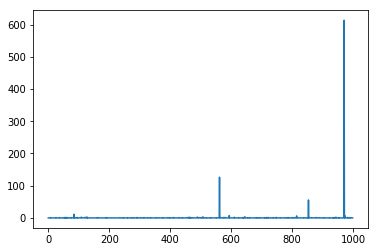

In [113]:
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [114]:
entropy(values)

tensor(3.0214)

In [ ]:
#on test
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
at batch no 100


In [84]:
n, hist, tk

(121,
 [(854, 21904.10),
  (971, 17531.10),
  (815, 1360.20),
  (808, 843.60),
  (84, 633.90),
  (594, 553.60),
  (645, 518.80),
  (509, 220.10),
  (973, 211.70),
  (646, 173.30),
  (944, 165.30),
  (109, 152.40),
  (748, 109.90),
  (800, 93.40),
  (354, 91.10),
  (735, 81.60),
  (824, 78.20),
  (506, 74.20),
  (839, 65.90),
  (878, 65.80),
  (946, 64.40),
  (581, 63.70),
  (582, 53.80),
  (879, 50.80),
  (611, 49.00),
  (300, 46.50),
  (992, 46.00),
  (790, 44.90),
  (679, 44.40),
  (533, 44.00),
  (687, 42.20),
  (459, 40.70),
  (911, 38.50),
  (497, 38.30),
  (621, 37.30),
  (468, 35.50),
  (737, 35.40),
  (721, 34.40),
  (580, 33.80),
  (788, 32.70),
  (955, 32.00),
  (898, 31.70),
  (738, 31.50),
  (128, 31.30),
  (489, 31.00),
  (794, 30.70),
  (982, 30.50),
  (865, 30.40),
  (323, 30.00),
  (987, 28.90),
  (476, 28.50),
  (723, 28.10),
  (455, 27.70),
  (880, 27.10),
  (741, 27.00),
  (885, 26.80),
  (136, 26.50),
  (304, 26.10),
  (709, 25.80),
  (411, 25.60),
  (241, 25.00),
 

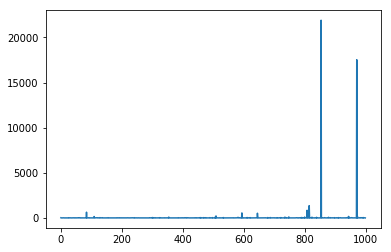

In [85]:
# on test
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [86]:
#on test
entropy(values)

tensor(2.9986)

In [ ]:
def make_triplet_samples(z, margin, r2, r3):
  positive_sample = z + random_vector_volume(z.shape, 0, margin).cuda() 
  negative_sample = z + random_vector_volume(z.shape, r2, r3).cuda()
  return positive_sample, negative_sample

def random_vector_surface(shape, r = 1.):
  mat = torch.randn(size=shape).cuda()
  norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
  return (mat/norm) * r

def random_vector_volume(shape, inner_r, outer_r):
  fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
  fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
  fraction.unsqueeze_(-1)
  return random_vector_surface(shape, 1) * fraction

In [ ]:
from collections import Counter

def most_frequent(x):
  return Counter(x).most_common(1)[0]

def preds_around(center, radius, n_preds, model, dummy_img):
  z_s = random_vector_volume([n_preds, 10], radius, radius + 0.01) + center[None]
  noises = model.forward_z(z_s)
  perturbed_imgs = noises + dummy_img 
  return torch.argmax(arch(perturbed_imgs), 1)
  
def most_freq_pred_around(center, radius, n_preds, model, dummy_img):
  preds = preds_around(center, radius, n_preds, model, dummy_img)
  most_freq = most_frequent(preds.tolist())
  return (class_index_to_label(most_freq[0]), most_freq[1]/n_preds)

def investigate_neighborhood(z, step, model, dummy_img):
  with torch.no_grad():
    result = []
    for radius in np.arange(0.1, 6., step):
#       print("creating {} more preds".format(int(10 + 5 * (radius ** 2))))
      most_freq_pred = most_freq_pred_around(z, radius, int(10 + 5 * (radius ** 2)), model, dummy_img)
      result.append((radius, most_freq_pred))
    return result

In [ ]:
#experiment 1

z = torch.tensor([0.5] * 10).cuda()
# z = torch.empty(10).uniform_(-1, 1).cuda()
# z_s = z[None]

model = learn.model.eval()
x_img = normalize(learn.data.train_ds[50][0].data.cuda())
  
for i in range(6):
  z = torch.empty(10).uniform_(-1, 1).cuda()
  print("investigation for: ", z)
  for elem in investigate_neighborhood(z, 0.5, model, x_img):
    print(elem)
print("done")

In [ ]:
#experiment 1-1: modified investigate_z
z_investigate_path = '/root/Derakhshani/adversarial/textual_notes/investigate_z_{}.txt'.format(env.save_filename)
if Path(z_investigate_path).exists(): raise FileExistsError("file already exists")
file = open(str(z_investigate_path), 'w')
        
for i, (z, noise) in enumerate(zip(pruned_z_s, pruned_noises)):
  hist = compute_prediction_histogram(learn, noise)
  indexed_hist = [(i, val) for i, val in enumerate(hist)]
  sorted_hist = sorted(indexed_hist, key=lambda x: x[1], reverse=True)
  labeled_hist = [(class_index_to_label(i), count) for i, count in sorted_hist]
  print("result {}:".format(i))
  print(big_vector_to_str(z))
  print(labeled_hist[:6])
  print("\n\n")
  
  file.write("result {}:\n".format(i))
  file.write(big_vector_to_str(z) + "\n")
  file.write(str(labeled_hist[:6]))
  file.write("\n\n\n")
  file.flush()

In [ ]:
#experiment 2
import itertools
z_s = [torch.tensor(t).cuda() for t in itertools.product( *([[-0.33, 0.33]] * 10) )]
model = learn.model.eval()
noises = []
with torch.no_grad():
  for z in z_s:
    noises.append(model.forward_single_z(z))

In [ ]:
x_img = normalize(learn.data.train_ds[50][0].data.cuda())

preds = []
for noise in noises:
  perturbed_img = x_img + noise
  preds.append(torch.argmax(arch(perturbed_img[None]), 1)[0].item())

from collections import Counter
result = [(class_index_to_label(index), count) for index, count in Counter(preds).most_common(5)]
result

In [ ]:
#experiment 3
import itertools
dimension_values = [[-0.9, 0.9]] * z_dim
for i in range(z_dim):
  if i % 100 != 0:
    dimension_values[i] = [0.]
# dimension_values[0] = [0.]
# dimension_values[3] = [0.]
# dimension_values[6] = [0.]
# dimension_values[9] = [0.]
pruned_z_s = [torch.tensor(t).cuda() for t in itertools.product(*dimension_values)]
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
#experiment 3: for the targeted-attack case
pruned_z_s = []
for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
#experiment 3-1: noises for 
pruned_z_s = []
# for i in range(z_dim):
#   new_z = torch.empty(z_dim).uniform_(0,1).cuda().detach()
#   pruned_z_s.append(new_z)

for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda().detach()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
for noise in pruned_noises[0:200]:
  img = noise_to_image(noise)
  img.show()

In [ ]:
# spider web
z_values = [
  [ 0.33, -0.33,  0.33,  0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33],
  [-0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33],
  [-0.33,  0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33,  0.33,  0.33],
  [-0.33,  0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33],
  [ 0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33, -0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33, -0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()


In [ ]:
z_values = [
  # window screen
  [-0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()

In [ ]:
#vgg-16_12 most repeated labels:
l = [(611, 215.0),
  (474, 194.1),
  (398, 120.3),
  (721, 79.6),
  (741, 73.5),
  (510, 62.5)]

[(class_index_to_label(index), count) for index, count in l]

In [ ]:
# learn.recorder.plot_losses()
# learn.recorder.plot_lr()
# learn.recorder.plot_metrics()

In [ ]:
fooling_rates = []
model = learn.model.eval()
learn.metrics = [validation_single_perturbation]
for i in range(10):
  global_perturbations = model(torch.rand(1, 3, 224, 244).cuda())[0]
  nag_util.global_perturbations = global_perturbations
  fooling_rates.append(learn.validate()[1].cpu().item())
  print("%d : %f"%(i, fooling_rates[-1]))

mean = np.mean(fooling_rates)
stddev = np.std(fooling_rates)
print(mean, stddev); print(fooling_rates)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[200][0]
x = normalize(x_img.data.cuda())
z = torch.tensor([-0.33,  0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33], dtype=torch.float32).cuda()
# z = torch.empty(z_dim).uniform_(-1,1).cuda()
p = model.forward_single_z(z).detach()

p_x = x + p
# print("img range, noise range")
# print_range(x); print_range(p)
adv_label = class_index_to_label(arch(p_x[None]).argmax(1).item())
print_big_vector(arch(p_x[None])[0])
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0., 1.])
p_img = Image(p)
x_img.show()
p_img.show()
p_x_img.show()


# print_range(p)
# print_range(denormalize(x))
# print_range(p_x)

benign_label = class_index_to_label(arch(x[None]).argmax(1).item())

print_big_vector(arch(x[None])[0])
print(benign_label, adv_label)

In [ ]:
z1 = torch.tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p1 = model.forward_single_z(z1)

z2 = torch.tensor([1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p2 = model.forward_single_z(z2)

z3 = torch.tensor([1, 1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p3 = model.forward_single_z(z3)

l2_distance(p1, p3)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[4][0]
x = x_img.data[None].cuda()
p = model(x)[0].squeeze().detach() 
x = x.squeeze()
x = normalize(x)

p_x = x + p
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0.,1.])
p_img = Image(p)
# x_img.show()
p_img.show()
# p_x_img.show()

print_range(p)
print_range(x)
print_range(p_x)